# Who feeds the world ? And how wealthy are they ?
There are **folium maps** in this notebook. If they do not display well, please **have a look at the `.html` file** from the same repository.

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)  
                
    3. [Structure of international trade and historical context](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    2. [Food self-sufficiency](#3B)

    3. [Analysis of food production and trade with GDP](#3C)

    4. [Food prices stability and agricultural features](#3D)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from operator import itemgetter
from sklearn import preprocessing
from tqdm import tqdm

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
#from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Food trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)        
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

Area Code                  Area  Item Code                     Item  \
1746112        225  United Arab Emirates       1720   Roots and Tubers,Total   
1736357        230               Ukraine        541         Fruit, stone nes   
629398          68                France        826  Tobacco, unmanufactured   
2023136       5105        Western Africa        813                     Coir   
1241851        160                  Niue        486                  Bananas   

         Element Code         Element  Year Code  Year    Unit    Value Flag  
1746112          5312  Area harvested       1979  1979      ha    180.0    A  
1736357          5510      Production       1994  1994  tonnes      NaN    M  
629398           5510      Production       1986  1986  tonnes  37520.0  NaN  
2023136          5510      Production       2013  2013  tonnes  41993.0    A  
1241851          5312  Area harvested       2013  2013      ha     40.0   Im

'Food trade'

Area Code                            Area  Item Code  \
8494039         146             Republic of Moldova        252   
12020027       5102                   Middle Africa        656   
8492103         146             Republic of Moldova        898   
14307882       5803  Small Island Developing States        128   
11438361        251                          Zambia       2030   

                          Item  Element Code          Element  Year Code  \
8494039   Oil, coconut (copra)          5910  Export Quantity       2001   
12020027         Coffee, green          5910  Export Quantity       2004   
8492103    Milk, skimmed dried          5910  Export Quantity       2001   
14307882         Cassava dried          5622     Import Value       2005   
11438361       Milk Equivalent          5610  Import Quantity       1962   

          Year      Unit    Value Flag  
8494039   2001    tonnes      0.0  NaN  
12020027  2004    tonnes  70441.0    A  
8492103   2001    tonnes   3781.0  NaN  
14307882  2005  1000 US$   1046.0    A  
11438361  1962    tonnes   5280.0    A

'Consumer price indices'

Area Code          Area  Item Code  \
41218        169      Paraguay      23013   
35992        142    Montserrat      23012   
8108         233  Burkina Faso      23012   
12659         48    Costa Rica      23012   
21037         84        Greece      23012   

                                                Item  Months Code     Months  \
41218     Consumer Prices, Food Indices (2010 = 100)         7002   February   
35992  Consumer Prices, General Indices (2010 = 100)         7009  September   
8108   Consumer Prices, General Indices (2010 = 100)         7010    October   
12659  Consumer Prices, General Indices (2010 = 100)         7004      April   
21037  Consumer Prices, General Indices (2010 = 100)         7009  September   

       Year Code  Year  Unit       Value Flag     Note  
41218       2013  2013   NaN  131.700000    X  2007M12  
35992       2004  2004   NaN   85.092180    X     2010  
8108        2010  2010   NaN   99.850374    X     2010  
12659       2003  2003   NaN   48.871655    X     2010  
21037       2002  2002   NaN   77.929942    X     2010

'Macroeconomy'

Area Code          Area  Item Code  \
150809         58       Ecuador      22076   
165748         62  Ethiopia PDR      22016   
219590        100         India      22078   
163172        238      Ethiopia      22008   
291715        134         Malta      22015   

                                                     Item  Element Code  \
150809  Value Added (Manufacture of food, beverages an...          6114   
165748    Value Added (Agriculture, Forestry and Fishing)          6109   
219590      Value Added (Manufacture of tobacco products)          6114   
163172                             Gross Domestic Product          6109   
291715                      Gross Fixed Capital Formation          6131   

                                  Element  Year Code  Year      Unit  \
150809  Value Local Currency, 2005 prices       2014  2014  millions   
165748               Value Local Currency       1972  1972  millions   
219590  Value Local Currency, 2005 prices       1980  1980  millions   
163172               Value Local Currency       2010  2010  millions   
291715     Annual growth US$, 2005 prices       1999  1999         %   

                Value Flag  
150809    2148.815455   Fc  
165748    3278.732722  XAM  
219590            NaN  NaN  
163172  379135.000000  XAM  
291715       3.704777   Fc

'Livestock production'

Area Code                     Area  Item Code                  Item  \
94853         117        Republic of Korea       1096                Horses   
135584       5104          Southern Africa       1746  Cattle and Buffaloes   
44275          74                    Gabon       1057              Chickens   
153067       5501  Australia & New Zealand       1034                  Pigs   
104435        200                Singapore       1068                 Ducks   

        Element Code Element  Year Code  Year       Unit       Value Flag  
94853           5111  Stocks       1995  1995       Head      6215.0  NaN  
135584          5111  Stocks       1969  1969       Head  16099899.0    A  
44275           5112  Stocks       1981  1981  1000 Head      1560.0    F  
153067          5111  Stocks       2007  2007       Head   2971352.0    A  
104435          5112  Stocks       1988  1988  1000 Head       657.0  NaN

'Live animals trade'

Area Code                                     Area  Item Code  \
324365        153                            New Caledonia        976   
560087       5203                         Northern America       1107   
662432       5817  Net Food Importing Developing Countries       1921   
167767         66                                     Fiji       1096   
31845          13                                  Bahrain       1096   

                   Item  Element Code          Element  Year Code  Year  \
324365            Sheep          5622     Import Value       2011  2011   
560087            Asses          5922     Export Value       1984  1984   
662432  Bovine, Animals          5908  Export Quantity       1965  1965   
167767           Horses          5608  Import Quantity       1969  1969   
31845            Horses          5608  Import Quantity       2006  2006   

            Unit      Value Flag  
324365  1000 US$        0.0    *  
560087  1000 US$        0.0    A  
662432      Head  1282113.0    A  
167767      Head        0.0  NaN  
31845       Head      157.0  NaN

At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unuseful data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>
The "Macroeconomy" dataset contains many different measures: Gross Fixed Capital Formation, Gross National Income, Value Added (Total Manufacturing), ... We are only interested in Gross Domestic Product. Therefore, we extract it Gross Domestic Product from the "Macroeconomy" dataset. In order to have uniformisation among values, we choose the US$ value. All of them have the same unit (millions US$) so we can drop the "Unit" column as well.

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

We can have have a look at a sample of the extrated dataset:

In [11]:
display(df_useful["GDP"].sample(5))

Area Code                Area  Year          Value
472990        219               Tonga  1975      42.521060
549507       5304  South-Eastern Asia  1999  584305.743955
391138        185  Russian Federation  1982            NaN
516365        237            Viet Nam  1973    3350.311755
76488          29             Burundi  1973     304.780492

And we can plot GDP in million US$ for different countries for the period 1970-2015:

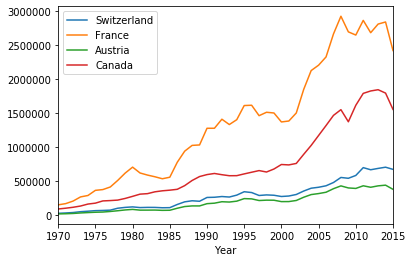

In [12]:
select_switzerland = df_useful["GDP"]['Area']=='Switzerland'
select_france = df_useful["GDP"]['Area']=='France'
select_austria = df_useful["GDP"]['Area']=='Austria'
select_canada = df_useful["GDP"]['Area']=='Canada'
ax = df_useful["GDP"][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

For dissolute or new countries, we have some Nan values (before appearing or after dissolution) as in this next example :

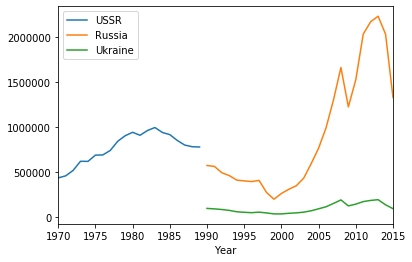

In [13]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>
We want to extract crops harvested area, production, seed and yield from the "Crops production" dataset. As all crops are not food crops, we request the [World crops database](https://world-crops.com/food-crops/) to keep only the food crops.

In [14]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [15]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

We check everything is fine by looking at samples for each of the new dataframes:

In [16]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

Area Code     Area                    Item  Year Unit    Value
2389410       5500  Oceania         Oil, palm fruit  1999   ha  76000.0
401050          45  Comoros                 Bananas  1973   ha   3600.0
285809          33   Canada  Peaches and nectarines  2001   ha   2600.0
1325120        170     Peru                     Rye  1987   ha   1700.0
602202          66     Fiji  Cucumbers and gherkins  1991   ha      NaN

Area Code                      Area         Item  Year    Unit  \
1776723        231  United States of America      Lentils  1994  tonnes   
208456          21                    Brazil  Rice, paddy  2005  tonnes   
367657          41           China, mainland     Tomatoes  1978  tonnes   
707644          87                Guadeloupe     Apricots  1992  tonnes   
1514346        198                  Slovenia          Rye  2002  tonnes   

              Value  
1776723     96000.0  
208456   13192863.0  
367657    5200000.0  
707644         21.0  
1514346      2038.0

Area Code          Area           Item  Year    Unit    Value
1705627        223        Turkey     Chick peas  1961  tonnes  10560.0
1074339        134         Malta          Wheat  2011  tonnes    390.0
2261894       5305  Western Asia  Cow peas, dry  1975  tonnes     50.0
101777          52    Azerbaijan       Potatoes  1993  tonnes  18500.0
1156884         28       Myanmar     Chick peas  1962  tonnes   6345.0

Area Code                                     Area  \
2529212       5803           Small Island Developing States   
2507704       5802         Land Locked Developing Countries   
1133158        143                                  Morocco   
2596484       5817  Net Food Importing Developing Countries   
2035714       5105                           Western Africa   

                              Item  Year   Unit     Value  
2529212     Mushrooms and truffles  2008  hg/ha  240000.0  
2507704                     Olives  1999  hg/ha   19950.0  
1133158  Fruit, tropical fresh nes  1990  hg/ha   50784.0  
2596484     Roots and Tubers,Total  1993  hg/ha   68173.0  
2035714    Jute & Jute-like Fibres  2006  hg/ha    8102.0

We also make some plots to have a first understanding of the dataset:

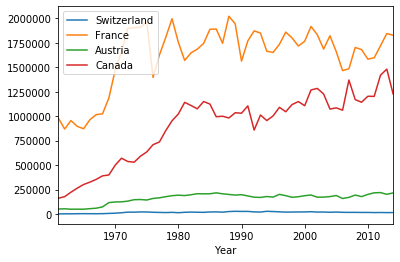

In [17]:
select_Maize = df_useful['Crops Area harvested']['Item']=='Maize'
maize_df = df_useful['Crops Area harvested'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

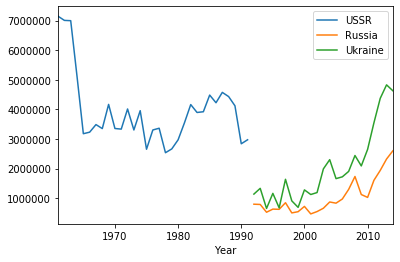

In [18]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

We want to extract stocks production from the "Livestock production" dataset. Again, we drop the columns that are useless for us and have a first look of the data with a sample and some plots.

In [19]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'
df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [20]:
display(df_useful['Livestock production'].sample(5))

Area Code                Area             Item  Year       Unit  \
110993        210              Sweden    Poultry Birds  2005  1000 Head   
99525         189         Saint Lucia            Sheep  1977       Head   
75945         141            Mongolia            Asses  2005       Head   
36009          56  Dominican Republic  Sheep and Goats  2005       Head   
91823         173              Poland         Chickens  1992  1000 Head   

           Value  
110993    6884.0  
99525    11293.0  
75945      450.0  
36009   495000.0  
91823    50202.0

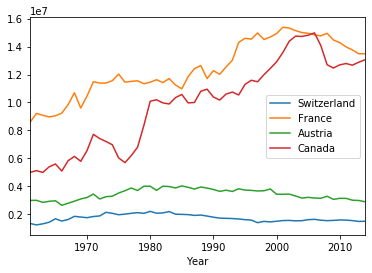

In [21]:
select_pigs = df_useful['Livestock production']['Item']=='Pigs'
pigs_df = df_useful['Livestock production'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

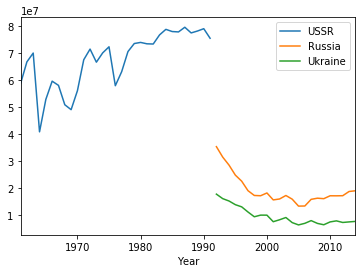

In [22]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>
Now, we extract import and export quantities from the "Live animals trade" and "Crops trade" datasets, having again some samples and some plots.

In [23]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [24]:
display(df_useful['Live animals import quantities'].sample(5))

Area Code                                       Area  \
307746        144                                 Mozambique   
307564        144                                 Mozambique   
455875        154  The former Yugoslav Republic of Macedonia   
338596        162                                     Norway   
413879        200                                  Singapore   

                    Item  Year  Unit     Value  
307746             Mules  1965  Head       NaN  
307564            Horses  1995  Head       0.0  
455875  Animals live nes  1997  Head       NaN  
338596   Camelids, other  1985  Head       NaN  
413879             Sheep  1961  Head  150000.0

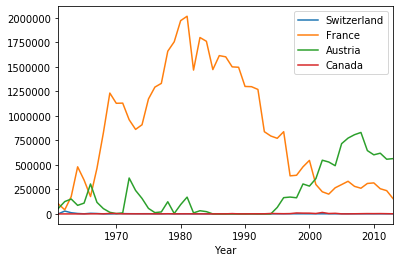

In [25]:
select_pigs = df_useful['Live animals import quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals import quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

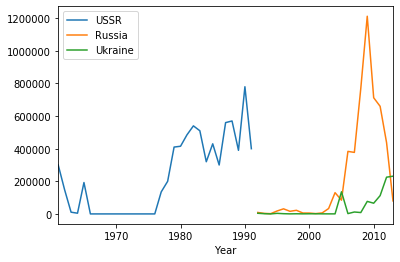

In [26]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [27]:
display(df_useful['Live animals export quantities'].sample(5))

Area Code      Area             Item  Year  Unit      Value
514058        181  Zimbabwe            Mules  1984  Head        NaN
534060       5100    Africa            Sheep  1980  Head  2557914.0
212043         95  Honduras  Sheep and Goats  1990  Head        0.0
114437         44  Colombia            Mules  1972  Head        NaN
559313       5200  Americas  Sheep and Goats  2005  Head   364698.0

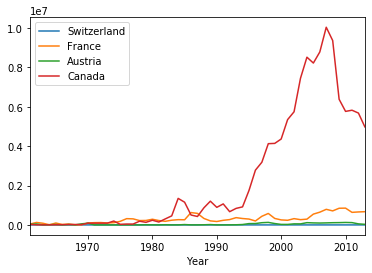

In [28]:
select_pigs = df_useful['Live animals export quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals export quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

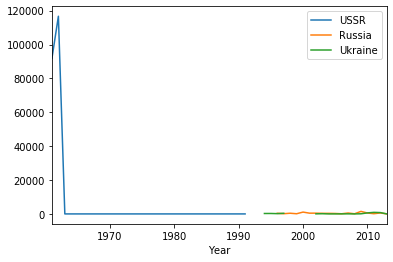

In [29]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [30]:
selection_import_quantities = df['Food trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Food trade']["Element"] == 'Export Quantity'

df_useful['Food import quantities'] = df['Food trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Food export quantities'] = df['Food trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [31]:
display(df_useful['Food import quantities'].sample(5))

Area Code                              Area  \
8147667        171                       Philippines   
6358620        132                          Maldives   
3664843         64                     Faroe Islands   
7435944        158                             Niger   
1204448         19  Bolivia (Plurinational State of)   

                             Item  Year    Unit     Value  
8147667                   Cereals  1966  tonnes  627094.0  
6358620   Coffee, husks and skins  1999  tonnes       NaN  
3664843  Alfalfa meal and pellets  2012  tonnes     642.0  
7435944                Hides, nes  1969  tonnes       NaN  
1204448             Cocoa, butter  1978  tonnes       0.0

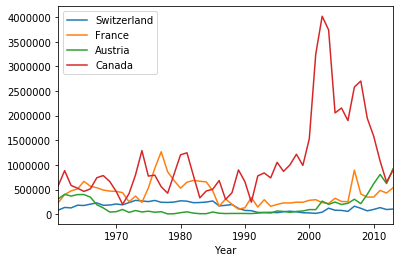

In [32]:
select_Maize = df_useful['Food import quantities']['Item']=='Maize'
maize_df = df_useful['Food import quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

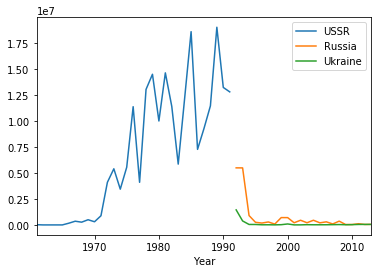

In [33]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [34]:
display(df_useful['Food export quantities'].sample(5))

Area Code             Area                         Item  Year  \
10585872        226           Uganda          Lettuce and chicory  1992   
6990102         147          Namibia  Pumpkins, squash and gourds  2003   
13369181       5401   Eastern Europe                      Lentils  1994   
3746649          66             Fiji       Peaches and nectarines  1986   
12177313       5104  Southern Africa         Cashew nuts, shelled  1996   

            Unit   Value  
10585872  tonnes     NaN  
6990102   tonnes     NaN  
13369181  tonnes  1383.0  
3746649   tonnes     NaN  
12177313  tonnes    23.0

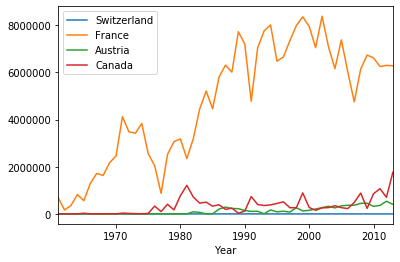

In [35]:
select_Maize = df_useful['Food export quantities']['Item']=='Maize'
maize_df = df_useful['Food export quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

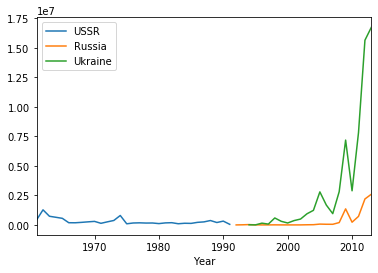

In [36]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

The "Consumer price indices" dataset contains monthly data. In order to have a uniform dataframe, and as other dataframes have yearly data, we group it by (Country, Year) and compute the mean over the monthes.

In [37]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area',"Year",'Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

With samples and plots, we remark that this dataset only start in 2000 wheareas other ones start in 1970.

In [38]:
display(df_useful['Consumer price indices'].sample(5))

Area  Year       Value
1504                     Italy  2009   99.159897
1049                      Fiji  2001   73.087129
3239  United States of America  2017  111.296312
2473       Republic of Moldova  2012  112.603221
1616                    Kosovo  2005   86.237421

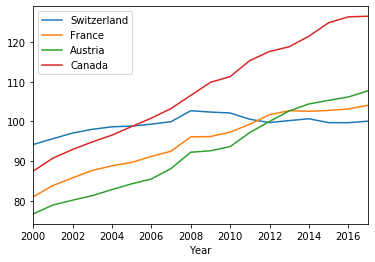

In [39]:
select_switzerland = df_useful['Consumer price indices']['Area']=='Switzerland'
select_france = df_useful['Consumer price indices']['Area']=='France'
select_austria = df_useful['Consumer price indices']['Area']=='Austria'
select_canada = df_useful['Consumer price indices']['Area']=='Canada'
ax = df_useful['Consumer price indices'][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful['Consumer price indices'][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

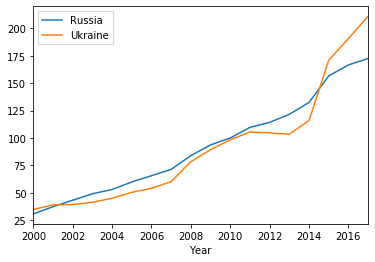

In [40]:
select_russia = df_useful["Consumer price indices"]['Area']=='Russian Federation'
select_ukraine = df_useful["Consumer price indices"]['Area']=='Ukraine'
ax = df_useful["Consumer price indices"][select_russia].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["Consumer price indices"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(['Russia', 'Ukraine'])

##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below $5000$ but not in $[261, 269]$.

In [41]:
#remove Area code >= 5000 or in [261, 269] (EU)
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<261 
        selection_countries = selection_countries | df_useful[df_name]['Area Code']>269
        selection_countries = selection_countries & df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


Area Code                         Area  Year         Value
104004         41              China, mainland  1993  6.230538e+05
127765         50                       Cyprus  2013  2.405627e+04
539139       5200                     Americas  1988  6.697983e+06
371141        171                  Philippines  2015  2.924491e+05
499925        215  United Republic of Tanzania  1996  9.604005e+03

Removing areas which are not countries in Crops Area harvested


Area Code                                       Area  \
1653786        154  The former Yugoslav Republic of Macedonia   
886663         106                                      Italy   
1714254        223                                     Turkey   
643885          70                           French Polynesia   
2593673       5817    Net Food Importing Developing Countries   

                             Item  Year Unit     Value  
1653786    Cucumbers and gherkins  1997   ha    1000.0  
886663                    Spinach  1996   ha    8000.0  
1714254                       Rye  1994   ha  146000.0  
643885   Vegetables&Melons, Total  1988   ha     714.0  
2593673               Watermelons  1989   ha  157044.0

Removing areas which are not countries in Crops Production


Area Code         Area         Item  Year    Unit     Value
77330           10    Australia       Olives  1962  tonnes     958.0
902955         110        Japan    Asparagus  1975  tonnes   21000.0
1142009        143      Morocco     Tomatoes  1994  tonnes  850390.0
1186520        150  Netherlands     Cherries  1982  tonnes    3900.0
2398356       5500      Oceania  Watermelons  1995  tonnes   81722.0

Removing areas which are not countries in Crops Seed


Area Code                                       Area  \
2253556       5304                         South-Eastern Asia   
726025          89                                  Guatemala   
724589          89                                  Guatemala   
1652841        154  The former Yugoslav Republic of Macedonia   
1167171        147                                    Namibia   

                           Item  Year    Unit   Value  
2253556                   Wheat  1966  tonnes  9035.0  
726025                 Potatoes  1999  tonnes  5000.0  
724589                     Okra  1971  tonnes     0.0  
1652841              Beans, dry  2014  tonnes  1500.0  
1167171  Groundnuts, with shell  1980  tonnes     0.0

Removing areas which are not countries in Crops Yield


Area Code                        Area                         Item  \
2376421       5404              Western Europe    Cereals (Rice Milled Eqv)   
800021         100                       India                      Lentils   
2111432       5206                   Caribbean  Chillies and peppers, green   
827806         102  Iran (Islamic Republic of)             Fruit, fresh nes   
17612            3                     Albania                        Wheat   

         Year   Unit     Value  
2376421  1968  hg/ha   35976.0  
800021   1978  hg/ha    4360.0  
2111432  2000  hg/ha   78184.0  
827806   2014  hg/ha  245118.0  
17612    2004  hg/ha   31130.0

Removing areas which are not countries in Livestock production


Area Code       Area                  Item  Year       Unit      Value
67619         123    Liberia  Cattle and Buffaloes  2012       Head    40000.0
56105         100      India                  Pigs  1976       Head  7400000.0
139539       5206  Caribbean              Chickens  1982  1000 Head    73897.0
64569         118     Kuwait         Poultry Birds  1981  1000 Head    12028.0
52088          91     Guyana              Beehives  1990         No     4100.0

Removing areas which are not countries in Live animals import quantities


Area Code           Area             Item  Year       Unit    Value
227709        103           Iraq           Cattle  1968       Head    107.0
457803        176    Timor-Leste  Bovine, Animals  1974       Head   1000.0
516447        261   EU(12)ex.int            Goats  1986       Head  16102.0
392224        189    Saint Lucia         Chickens  2004  1000 Head    352.0
325013        153  New Caledonia  Sheep and Goats  1970       Head      0.0

Removing areas which are not countries in Live animals export quantities


Area Code                        Area              Item  Year  Unit  \
452804        216                    Thailand         Buffaloes  1969  Head   
595852       5305                Western Asia  Animals live nes  2006  Head   
644377       5801   Least Developed Countries             Sheep  1974  Head   
226566        102  Iran (Islamic Republic of)             Sheep  1991  Head   
460540        217                        Togo   Sheep and Goats  2008  Head   

            Value  
452804    25831.0  
595852        0.0  
644377  1852254.0  
226566    25000.0  
460540        0.0

Removing areas which are not countries in Food import quantities


Area Code       Area                       Item  Year    Unit   Value
9377171        201    Somalia                    Lactose  2013  tonnes     0.0
4145119         79    Germany                Eggs, dried  2013  tonnes  7345.0
5001666        101  Indonesia  Hides, cattle, wet salted  1974  tonnes     0.0
2168147        351      China               Maize, green  1967  tonnes     NaN
1699016         29    Burundi         Tea, mate extracts  1992  tonnes     NaN

Removing areas which are not countries in Food export quantities


Area Code             Area                      Item  Year    Unit  \
11332377        248     Yugoslav SFR  Alfalfa meal and pellets  1970  tonnes   
11538891        261     EU(12)ex.int           Meat, dried nes  2006  tonnes   
12576337       5204  Central America     Vegetables in vinegar  1983  tonnes   
10376689        222          Tunisia          Butter, cow milk  1972  tonnes   
4718508          95         Honduras                 Plantains  1995  tonnes   

            Value  
11332377      0.0  
11538891  13404.0  
12576337  25951.0  
10376689      0.0  
4718508    8048.0

Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

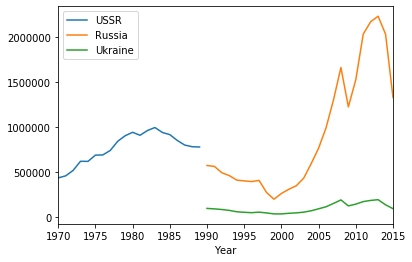

In [42]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In order to vizualize folium maps, we need to associate each country a value. The geojson file that we use is not timestamped and only countries that exist nowadays are inside it. As some countries has been dissolved during the past 50 years, our folium maps won't be complete. For instance, we do not have any value for Ukraine from 1970 to 1989. Our idea to fix this issue is presented in the next paragraph.

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


Our idea is to map the former country value to each of the current ones. For instance in 1982, USSR GDP is around one trillion $. Therefore, if we associate (only for folium map purposes) this value to each current country that succeeded USSR, all these countries will appear the same color in the folium map, i.e. all the USSR area will appear the same color (and the good one).

In order to do so, one need to identify which countries appeared and disappeared from the dataset and at which year. Then we will use this result along with some historical research in our `visualise_world_data_folium` function ([1Ea](#1Ea)).

In [43]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
for year in sorted(list(countries_formation_years)):
    print (year, countries_formation_years[year])

1988 [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]
1989 [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')]
1990 [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+'), ('Central Asia', '+')]
1999 [('Kosovo', '+')]
2005 [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')]
2007 [('Sudan (former)', '-')]
2008 [('South Sudan', '+'), ('Sudan', '+')]
2012 [('Netherlands Antilles (former)', '-')]


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>
Some countries have different names in the geojson file and in the dataset. We first start by correcting them.

In [44]:
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea"}

def correct_country_names(old_name):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name


In [45]:
for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(correct_country_names)

GDP
Crops Area harvested
Crops Production
Crops Seed
Crops Yield
Livestock production
Live animals import quantities
Live animals export quantities
Food import quantities
Food export quantities
Consumer price indices


Then, we do a function that takes as input a dataframe and a year and produces the corresponding folium map. This function also handles dissolutions of countries as suggested [before](#1Dbii).

In [46]:
def visualise_world_data_folium(df, year, logScale=True):
    dic = {'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
           'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
           'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
           'Yemen Dem' :                       ['Yemen'],        
           'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
           'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
           'Sudan (former)':                   ['South Sudan', 'Sudan']
          }
    def add_new_names(old_name):
        if old_name in dic.keys() :
            return dic[old_name]
        return old_name
    to_plot=df[df["Year"]==year]
    to_plot=(to_plot[['Area','Value']]
             .dropna()
             .groupby('Area')             
             .mean()
             .reset_index()
             .dropna())    
    to_plot['Area']=to_plot['Area'].apply(add_new_names)
    to_plot = to_plot.explode('Area')
    if logScale :
        to_plot.Value=np.log10(to_plot.Value)
    
    m = folium.Map(location=[40,-10],zoom_start=1.6)
    folium.Choropleth(
        geo_data=f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
        data=to_plot,
        columns=['Area', 'Value'],
        key_on='feature.properties.name',
        fill_color='YlGn',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return(m)

We can know use it to produce some maps. For instance, we plot below the map of GDP for the year 1985 (befor edissolution of USSR).

In [47]:
display(visualise_world_data_folium(df_useful["GDP"], 1985, True))

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

Some of our features seem to be right skewed. At first glance it seems that they look like power laws.

For instance the distribution of GDP look a bit like a power law:

C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


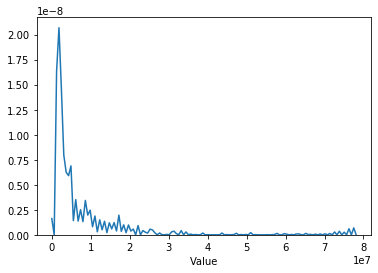

In [48]:
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

As we later want to train some Machine Learning models, we log those values so that their distribution look a bit more like a normal distribution.

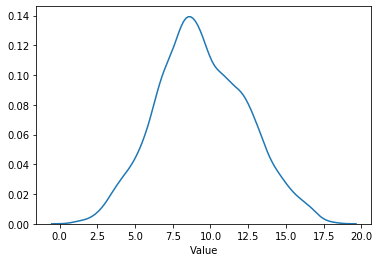

In [49]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

The new distribution indeed looks better to train models on it.

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation columns | CPI
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

The current dataframes have several rows for a given `(Country, Year)`. Each of this row correspond to one item. We would like to have a unique row for a given `(Country, Year)` and one column per item:

In [50]:
need_pivot = ['Crops Area harvested',
              'Crops Production',
              'Crops Seed',
              'Crops Yield',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Food import quantities',
              'Food export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_useful[df_name].sample(5))

Item                  Anise, badian, fennel, coriander Crops Area harvested  \
Unit                                                                     ha   
Area             Year                                                         
Yugoslav SFR     1987                                             2100.0      
Mauritius        2010                                                NaN      
Northern America 1983                                                0.0      
Turkey           2010                                            18135.0      
Puerto Rico      1986                                                NaN      

Item                  Apples Crops Area harvested  \
Unit                                           ha   
Area             Year                               
Yugoslav SFR     1987                     50300.0   
Mauritius        2010                         NaN   
Northern America 1983                    210970.0   
Turkey           2010                    165078.0   
Puerto Rico      1986                         NaN   

Item                  Apricots Crops Area harvested  \
Unit                                             ha   
Area             Year                                 
Yugoslav SFR     1987                        6400.0   
Mauritius        2010                           NaN   
Northern America 1983                        9250.0   
Turkey           2010                       59801.0   
Puerto Rico      1986                           NaN   

Item                  Areca nuts Crops Area harvested  \
Unit                                               ha   
Area             Year                                   
Yugoslav SFR     1987                             NaN   
Mauritius        2010                             NaN   
Northern America 1983                             NaN   
Turkey           2010                             NaN   
Puerto Rico      1986                             NaN   

Item                  Artichokes Crops Area harvested  \
Unit                                               ha   
Area             Year                                   
Yugoslav SFR     1987                             NaN   
Mauritius        2010                             NaN   
Northern America 1983                          4791.0   
Turkey           2010                          2400.0   
Puerto Rico      1986                             NaN   

Item                  Asparagus Crops Area harvested  \
Unit                                              ha   
Area             Year                                  
Yugoslav SFR     1987                            NaN   
Mauritius        2010                            NaN   
Northern America 1983                        35550.0   
Turkey           2010                            7.0   
Puerto Rico      1986                            NaN   

Item                  Avocados Crops Area harvested  \
Unit                                             ha   
Area             Year                                 
Yugoslav SFR     1987                           NaN   
Mauritius        2010                           NaN   
Northern America 1983                       33590.0   
Turkey           2010                         146.0   
Puerto Rico      1986                        1050.0   

Item                  Bambara beans Crops Area harvested  \
Unit                                                  ha   
Area             Year                                      
Yugoslav SFR     1987                                NaN   
Mauritius        2010                                NaN   
Northern America 1983                                NaN   
Turkey           2010                                NaN   
Puerto Rico      1986                                NaN   

Item                  Bananas Crops Area harvested  \
Unit                                            ha   
Area             Year                                
Yugoslav SFR     1987                          NaN   


Item                 Anise, badian, fennel, coriander Crops Production  \
Unit                                                            tonnes   
Area            Year                                                     
Jordan          1997                                               NaN   
Suriname        1989                                               NaN   
Bulgaria        1988                                               NaN   
Central America 2000                                           33408.0   
Costa Rica      1970                                               NaN   

Item                 Apples Crops Production Apricots Crops Production  \
Unit                                  tonnes                    tonnes   
Area            Year                                                     
Jordan          1997                 31000.0                    3187.0   
Suriname        1989                     NaN                       NaN   
Bulgaria        1988                334463.0                   34509.0   
Central America 2000                366665.0                    2067.0   
Costa Rica      1970                     NaN                       NaN   

Item                 Areca nuts Crops Production Artichokes Crops Production  \
Unit                                      tonnes                      tonnes   
Area            Year                                                           
Jordan          1997                         NaN                         0.0   
Suriname        1989                         NaN                         NaN   
Bulgaria        1988                         NaN                         NaN   
Central America 2000                         NaN                      3038.0   
Costa Rica      1970                         NaN                         NaN   

Item                 Asparagus Crops Production Avocados Crops Production  \
Unit                                     tonnes                    tonnes   
Area            Year                                                        
Jordan          1997                        NaN                       NaN   
Suriname        1989                        NaN                       NaN   
Bulgaria        1988                        NaN                       NaN   
Central America 2000                    50531.0                 1001414.0   
Costa Rica      1970                        NaN                   16300.0   

Item                 Bambara beans Crops Production Bananas Crops Production  \
Unit                                         tonnes                   tonnes   
Area            Year                                                           
Jordan          1997                            NaN                  18151.0   
Suriname        1989                            NaN                  45943.0   
Bulgaria        1988                            NaN                      NaN   
Central America 2000                            NaN                6246081.0   
Costa Rica      1970                            NaN                1146307.0   

Item                 Barley Crops Production  ...  \
Unit                                  tonnes  ...   
Area            Year                          ...   
Jordan          1997                 43280.0  ...   
Suriname        1989                     NaN  ...   
Bulgaria        1988               1312655.0  ...   
Central America 2000                714070.0  ...   
Costa Rica      1970                     NaN  ...   

Item                 Sweet potatoes Crops Production  \
Unit                                          tonnes   
Area            Year                                   
Jordan          1997                             NaN   
Suriname        1989                            47.0   
Bulgaria        1988                             NaN   
Central America 2000                         54477.0   
Costa Rica      1970                             NaN   

Item                 Tangerines, mandarin

Item               Anise, badian, fennel, coriander Crops Seed  \
Unit                                                    tonnes   
Area          Year                                               
Kyrgyzstan    2000                                         NaN   
Southern Asia 2004                                         NaN   
Guatemala     1963                                         NaN   
Peru          1976                                         NaN   
Eastern Asia  1988                                         NaN   

Item               Bambara beans Crops Seed Bananas Crops Seed  \
Unit                                 tonnes             tonnes   
Area          Year                                               
Kyrgyzstan    2000                      NaN                NaN   
Southern Asia 2004                      NaN                NaN   
Guatemala     1963                      NaN                NaN   
Peru          1976                      NaN                NaN   
Eastern Asia  1988                      NaN                NaN   

Item               Barley Crops Seed Beans, dry Crops Seed  \
Unit                          tonnes                tonnes   
Area          Year                                           
Kyrgyzstan    2000           16000.0                   NaN   
Southern Asia 2004          220882.0              264571.0   
Guatemala     1963               2.0                4232.0   
Peru          1976           13578.0                4049.0   
Eastern Asia  1988          171354.0              140380.0   

Item               Broad beans, horse beans, dry Crops Seed  \
Unit                                                 tonnes   
Area          Year                                            
Kyrgyzstan    2000                                      NaN   
Southern Asia 2004                                    157.0   
Guatemala     1963                                   1074.0   
Peru          1976                                   1247.0   
Eastern Asia  1988                                 168060.0   

Item               Buckwheat Crops Seed  \
Unit                             tonnes   
Area          Year                        
Kyrgyzstan    2000                  NaN   
Southern Asia 2004                531.0   
Guatemala     1963                  NaN   
Peru          1976                  NaN   
Eastern Asia  1988             153240.0   

Item               Cabbages and other brassicas Crops Seed  \
Unit                                                tonnes   
Area          Year                                           
Kyrgyzstan    2000                                     NaN   
Southern Asia 2004                                     NaN   
Guatemala     1963                                     NaN   
Peru          1976                                     NaN   
Eastern Asia  1988                                     NaN   

Item               Carrots and turnips Crops Seed Cassava Crops Seed  ...  \
Unit                                       tonnes             tonnes  ...   
Area          Year                                                    ...   
Kyrgyzstan    2000                            NaN                NaN  ...   
Southern Asia 2004                            NaN                NaN  ...   
Guatemala     1963                            NaN                NaN  ...   
Peru          1976                            NaN                NaN  ...   
Eastern Asia  1988                            NaN                NaN  ...   

Item               Sorghum Crops Seed Soybeans Crops Seed  \
Unit                           tonnes              tonnes   
Area          Year                                          
Kyrgyzstan    2000                2.0                 NaN   
Southern Asia 2004           277871.0            471320.0   
Guatemala     1963              470.0                 0.0   
Peru          1976              337.0               101.0   
Eastern Asia  1988            57647.0            89058

Item                     Anise, badian, fennel, coriander Crops Yield  \
Unit                                                            hg/ha   
Area                Year                                                
South-Eastern Asia  1987                                       8438.0   
New Caledonia       2010                                          NaN   
Somalia             1963                                          NaN   
Trinidad and Tobago 1999                                          NaN   
Kuwait              1963                                          NaN   

Item                     Apples Crops Yield Apricots Crops Yield  \
Unit                                  hg/ha                hg/ha   
Area                Year                                           
South-Eastern Asia  1987                NaN                  NaN   
New Caledonia       2010                NaN                  NaN   
Somalia             1963                NaN                  NaN   
Trinidad and Tobago 1999                NaN                  NaN   
Kuwait              1963                NaN                  NaN   

Item                     Areca nuts Crops Yield Artichokes Crops Yield  \
Unit                                      hg/ha                  hg/ha   
Area                Year                                                 
South-Eastern Asia  1987                 6066.0                    NaN   
New Caledonia       2010                    NaN                    NaN   
Somalia             1963                    NaN                    NaN   
Trinidad and Tobago 1999                    NaN                    NaN   
Kuwait              1963                    NaN                    NaN   

Item                     Asparagus Crops Yield Avocados Crops Yield  \
Unit                                     hg/ha                hg/ha   
Area                Year                                              
South-Eastern Asia  1987                   NaN              40077.0   
New Caledonia       2010                   NaN                  NaN   
Somalia             1963                   NaN                  NaN   
Trinidad and Tobago 1999                   NaN              56056.0   
Kuwait              1963                   NaN                  NaN   

Item                     Bambara beans Crops Yield Bananas Crops Yield  \
Unit                                         hg/ha               hg/ha   
Area                Year                                                 
South-Eastern Asia  1987                       NaN            130625.0   
New Caledonia       2010                       NaN             31953.0   
Somalia             1963                       NaN            114545.0   
Trinidad and Tobago 1999                       NaN             50773.0   
Kuwait              1963                       NaN                 NaN   

Item                     Barley Crops Yield  ... Sweet potatoes Crops Yield  \
Unit                                  hg/ha  ...                      hg/ha   
Area                Year                     ...                              
South-Eastern Asia  1987            10935.0  ...                    69153.0   
New Caledonia       2010                NaN  ...                    25122.0   
Somalia             1963                NaN  ...                   100000.0   
Trinidad and Tobago 1999                NaN  ...                    63429.0   
Kuwait              1963                NaN  ...                        NaN   

Item                     Tangerines, mandarins, clementines, satsumas Crops Yield  \
Unit                                                                        hg/ha   
Area                Year                                                            
South-Eastern Asia  1987                                           140334.0         
New Caledonia       2010                                                NaN         
Somalia             1963                                 

Item                                   Animals live nes Livestock production  \
Unit                                                                    Head   
Area                              Year                                         
Low Income Food Deficit Countries 1962                                   NaN   
Thailand                          1999                                   NaN   
Caribbean                         2010                                   NaN   
Micronesia (Federated States of)  2011                                   NaN   
Solomon Islands                   2003                                   NaN   

Item                                   Asses Livestock production  \
Unit                                                         Head   
Area                              Year                              
Low Income Food Deficit Countries 1962                 11259571.0   
Thailand                          1999                       30.0   
Caribbean                         2010                   410036.0   
Micronesia (Federated States of)  2011                        NaN   
Solomon Islands                   2003                        NaN   

Item                                   Beehives Livestock production  \
Unit                                         No Livestock production   
Area                              Year                                 
Low Income Food Deficit Countries 1962                     9870735.0   
Thailand                          1999                           NaN   
Caribbean                         2010                      351130.0   
Micronesia (Federated States of)  2011                           NaN   
Solomon Islands                   2003                           NaN   

Item                                   Buffaloes Livestock production  \
Unit                                                             Head   
Area                              Year                                  
Low Income Food Deficit Countries 1962                     59792708.0   
Thailand                          1999                      1911518.0   
Caribbean                         2010                         5900.0   
Micronesia (Federated States of)  2011                          155.0   
Solomon Islands                   2003                            NaN   

Item                                   Camelids, other Livestock production  \
Unit                                                                   Head   
Area                              Year                                        
Low Income Food Deficit Countries 1962                                  NaN   
Thailand                          1999                                  NaN   
Caribbean                         2010                                  NaN   
Micronesia (Federated States of)  2011                                  NaN   
Solomon Islands                   2003                                  NaN   

Item                                   Camels Livestock production  \
Unit                                                          Head   
Area                              Year                               
Low Income Food Deficit Countries 1962                   9977310.0   
Thailand                          1999                         NaN   
Caribbean                         2010                         NaN   
Micronesia (Federated States of)  2011                         NaN   
Solomon Islands                   2003                         NaN   

Item                                   Cattle Livestock production  \
Unit                                                          Head   
Area                              Year                               
Low Income Food Deficit Countries 1962                 321679193.0   
Thailand                          1999                   4755792.0   
Caribbean                         2010                   9104337.0   
Micronesia (Federated States o

Item                    Animals live nes Live animals import quantities  \
Unit                                                               Head   
Area               Year                                                   
EU(12)ex.int       1986                                            35.0   
South-Eastern Asia 2003                                             0.0   
Egypt              1969                                             0.0   
Hungary            2007                                             0.0   
Malaysia           1979                                             NaN   

Item                    Asses Live animals import quantities  \
Unit                                                    Head   
Area               Year                                        
EU(12)ex.int       1986                               2279.0   
South-Eastern Asia 2003                                101.0   
Egypt              1969                                  0.0   
Hungary            2007                                  NaN   
Malaysia           1979                                  0.0   

Item                    Beehives Live animals import quantities  \
Unit                          No Live animals import quantities   
Area               Year                                           
EU(12)ex.int       1986                                     NaN   
South-Eastern Asia 2003                                     NaN   
Egypt              1969                                     0.0   
Hungary            2007                                     NaN   
Malaysia           1979                                     NaN   

Item                    Bovine, Animals Live animals import quantities  \
Unit                                                              Head   
Area               Year                                                  
EU(12)ex.int       1986                                       483364.0   
South-Eastern Asia 2003                                       594330.0   
Egypt              1969                                         2329.0   
Hungary            2007                                        14033.0   
Malaysia           1979                                        35385.0   

Item                    Buffaloes Live animals import quantities  \
Unit                                                        Head   
Area               Year                                            
EU(12)ex.int       1986                                      NaN   
South-Eastern Asia 2003                                  41169.0   
Egypt              1969                                      0.0   
Hungary            2007                                      NaN   
Malaysia           1979                                    314.0   

Item                    Camelids, other Live animals import quantities  \
Unit                                                              Head   
Area               Year                                                  
EU(12)ex.int       1986                                            NaN   
South-Eastern Asia 2003                                            NaN   
Egypt              1969                                            NaN   
Hungary            2007                                            NaN   
Malaysia           1979                                            NaN   

Item                    Camels Live animals import quantities  \
Unit                                                     Head   
Area               Year                                         
EU(12)ex.int       1986                                   NaN   
South-Eastern Asia 2003                                   NaN   
Egypt              1969                               37300.0   
Hungary            2007                                   NaN   
Malaysia           1979                                   NaN   

Item                    Cattle Live animals import quantities  \
Unit                            

Item                   Animals live nes Live animals export quantities  \
Unit                                                              Head   
Area              Year                                                   
Jordan            1965                                             0.0   
Western Asia      1971                                             0.0   
Kenya             1991                                             0.0   
Brunei Darussalam 2000                                             NaN   
Fiji              2013                                             0.0   

Item                   Asses Live animals export quantities  \
Unit                                                   Head   
Area              Year                                        
Jordan            1965                                  NaN   
Western Asia      1971                                  0.0   
Kenya             1991                                  0.0   
Brunei Darussalam 2000                                  NaN   
Fiji              2013                                  NaN   

Item                   Beehives Live animals export quantities  \
Unit                         No Live animals export quantities   
Area              Year                                           
Jordan            1965                                     NaN   
Western Asia      1971                                     0.0   
Kenya             1991                                     NaN   
Brunei Darussalam 2000                                     NaN   
Fiji              2013                                     NaN   

Item                   Bovine, Animals Live animals export quantities  \
Unit                                                             Head   
Area              Year                                                  
Jordan            1965                                            0.0   
Western Asia      1971                                        94010.0   
Kenya             1991                                         7012.0   
Brunei Darussalam 2000                                           60.0   
Fiji              2013                                            1.0   

Item                   Buffaloes Live animals export quantities  \
Unit                                                       Head   
Area              Year                                            
Jordan            1965                                      NaN   
Western Asia      1971                                      0.0   
Kenya             1991                                      NaN   
Brunei Darussalam 2000                                      0.0   
Fiji              2013                                      NaN   

Item                   Camelids, other Live animals export quantities  \
Unit                                                             Head   
Area              Year                                                  
Jordan            1965                                            NaN   
Western Asia      1971                                            NaN   
Kenya             1991                                            NaN   
Brunei Darussalam 2000                                            NaN   
Fiji              2013                                            NaN   

Item                   Camels Live animals export quantities  \
Unit                                                    Head   
Area              Year                                         
Jordan            1965                                   0.0   
Western Asia      1971                                 708.0   
Kenya             1991                                   NaN   
Brunei Darussalam 2000                                   NaN   
Fiji              2013                                   NaN   

Item                   Cattle Live animals export quantities  \
Unit                                                    Head   
Area              Year   

Item                          Alfalfa meal and pellets Food import quantities  \
Unit                                                                   tonnes   
Area                     Year                                                   
Northern Africa          1980                                             0.0   
Vanuatu                  1964                                             NaN   
United States of America 1969                                             0.0   
Seychelles               1990                                             NaN   
Morocco                  1990                                             0.0   

Item                          Almonds shelled Food import quantities  \
Unit                                                          tonnes   
Area                     Year                                          
Northern Africa          1980                                 3202.0   
Vanuatu                  1964                                    NaN   
United States of America 1969                                    0.0   
Seychelles               1990                                    0.0   
Morocco                  1990                                   92.0   

Item                          Animal Oil+Fat+Grs Food import quantities  \
Unit                                                             tonnes   
Area                     Year                                             
Northern Africa          1980                                  283345.0   
Vanuatu                  1964                                       0.0   
United States of America 1969                                    7091.0   
Seychelles               1990                                      95.0   
Morocco                  1990                                    9961.0   

Item                          Animal Vegetable Oil Food import quantities  \
Unit                                                               tonnes   
Area                     Year                                               
Northern Africa          1980                                   1148591.0   
Vanuatu                  1964                                       147.0   
United States of America 1969                                    478900.0   
Seychelles               1990                                      1033.0   
Morocco                  1990                                    180312.0   

Item                          Animal fats Food import quantities  \
Unit                                                      tonnes   
Area                     Year                                      
Northern Africa          1980                           283345.0   
Vanuatu                  1964                                0.0   
United States of America 1969                             7091.0   
Seychelles               1990                               95.0   
Morocco                  1990                             9961.0   

Item                          Anise, badian, fennel, coriander Food import quantities  \
Unit                                                                           tonnes   
Area                     Year                                                           
Northern Africa          1980                                             2999.0        
Vanuatu                  1964                                                NaN        
United States of America 1969                                             7345.0        
Seychelles               1990                                               15.0        
Morocco                  1990                                             1497.0        

Item                          Apples Food import quantities  \
Unit                                                 tonnes   
Area                     Year                                 
Northern Africa          1980                       49871.0   
Vanuatu                  1964                 

Item                Alfalfa meal and pellets Food export quantities  \
Unit                                                         tonnes   
Area           Year                                                   
EU(15)ex.int   1990                                         29968.0   
European Union 1987                                        393374.0   
Sweden         2008                                            51.0   
Afghanistan    1985                                             NaN   
Bahrain        1979                                             NaN   

Item                Almonds shelled Food export quantities  \
Unit                                                tonnes   
Area           Year                                          
EU(15)ex.int   1990                                 5095.0   
European Union 1987                                40796.0   
Sweden         2008                                  300.0   
Afghanistan    1985                                    0.0   
Bahrain        1979                                    NaN   

Item                Animal Oil+Fat+Grs Food export quantities  \
Unit                                                   tonnes   
Area           Year                                             
EU(15)ex.int   1990                                   65541.0   
European Union 1987                                  763394.0   
Sweden         2008                                   15993.0   
Afghanistan    1985                                       NaN   
Bahrain        1979                                       1.0   

Item                Animal Vegetable Oil Food export quantities  \
Unit                                                     tonnes   
Area           Year                                               
EU(15)ex.int   1990                                   2303944.0   
European Union 1987                                   6877064.0   
Sweden         2008                                    240302.0   
Afghanistan    1985                                         NaN   
Bahrain        1979                                         8.0   

Item                Animal fats Food export quantities  \
Unit                                            tonnes   
Area           Year                                      
EU(15)ex.int   1990                            65541.0   
European Union 1987                           763394.0   
Sweden         2008                            15993.0   
Afghanistan    1985                                NaN   
Bahrain        1979                                1.0   

Item                Anise, badian, fennel, coriander Food export quantities  \
Unit                                                                 tonnes   
Area           Year                                                           
EU(15)ex.int   1990                                             4745.0        
European Union 1987                                            12680.0        
Sweden         2008                                               60.0        
Afghanistan    1985                                                NaN        
Bahrain        1979                                                NaN        

Item                Apples Food export quantities  \
Unit                                       tonnes   
Area           Year                                 
EU(15)ex.int   1990                       54223.0   
European Union 1987                     2100091.0   
Sweden         2008                         873.0   
Afghanistan    1985                        3298.0   
Bahrain        1979                          55.0   

Item                Apricots Food export quantities  \
Unit                                         tonnes   
Area           Year                                   
EU(15)ex.int   1990                          8756.0   
European Union 1987                         79137.0   
Sweden         2008                            13.0   
Afghanistan    1985    

Some Nan values have appeared. As we have datasets that have great outliers, we would replace those Nan values by the median of the column:

In [51]:
# Deal with the NaN that appeared
for df_name in df_useful :
    for column in list(df_useful[df_name]):
        if column not in ['Area', 'Year']:
            df_useful[df_name][column].fillna(0, inplace=True)

In [52]:
#removing the multiindex, so that merge is clean with GDP and CPI
for df_name in need_pivot :
    df_useful[df_name].columns = [' '.join([str(_) for _ in v]) for v in df_useful[df_name].columns.values]
    display(df_useful[df_name].sample(5))
    

Anise, badian, fennel, coriander Crops Area harvested ha  \
Area         Year                                                             
Martinique   1985                                                0.0          
Sierra Leone 1987                                                0.0          
Mauritania   1988                                                0.0          
Slovenia     2001                                                0.0          
Réunion      1961                                                0.0          

                   Apples Crops Area harvested ha  \
Area         Year                                   
Martinique   1985                             0.0   
Sierra Leone 1987                             0.0   
Mauritania   1988                             0.0   
Slovenia     2001                          3081.0   
Réunion      1961                             0.0   

                   Apricots Crops Area harvested ha  \
Area         Year                                     
Martinique   1985                               0.0   
Sierra Leone 1987                               0.0   
Mauritania   1988                               0.0   
Slovenia     2001                              43.0   
Réunion      1961                               0.0   

                   Areca nuts Crops Area harvested ha  \
Area         Year                                       
Martinique   1985                                 0.0   
Sierra Leone 1987                                 0.0   
Mauritania   1988                                 0.0   
Slovenia     2001                                 0.0   
Réunion      1961                                 0.0   

                   Artichokes Crops Area harvested ha  \
Area         Year                                       
Martinique   1985                                 0.0   
Sierra Leone 1987                                 0.0   
Mauritania   1988                                 0.0   
Slovenia     2001                                 0.0   
Réunion      1961                                 0.0   

                   Asparagus Crops Area harvested ha  \
Area         Year                                      
Martinique   1985                                0.0   
Sierra Leone 1987                                0.0   
Mauritania   1988                                0.0   
Slovenia     2001                                0.0   
Réunion      1961                                0.0   

                   Avocados Crops Area harvested ha  \
Area         Year                                     
Martinique   1985                             600.0   
Sierra Leone 1987                               0.0   
Mauritania   1988                               0.0   
Slovenia     2001                               0.0   
Réunion      1961                               0.0   

                   Bambara beans Crops Area harvested ha  \
Area         Year                                          
Martinique   1985                                    0.0   
Sierra Leone 1987                                    0.0   
Mauritania   1988                                    0.0   
Slovenia     2001                                    0.0   
Réunion      1961                                    0.0   

                   Bananas Crops Area harvested ha  \
Area         Year                                    
Martinique   1985                           6700.0   
Sierra Leone 1987                              0.0   
Mauritania   1988                              0.0   
Slovenia     2001                              0.0   
Réunion      1961                            350.0   

                   Barley Crops Area harvested ha  ...  \
Area         Year                                  ...   
Martinique   1985                             0.0  ...   
Sierra Leone 1987                             0.0  ...   
Mauritania   1988                           380.0  ...   
Slovenia     2001                     

Anise, badian, fennel, coriander Crops Production tonnes  \
Area              Year                                                             
Nauru             1964                                                0.0          
Brunei Darussalam 1994                                                0.0          
Senegal           1999                                                0.0          
Turkmenistan      1997                                                0.0          
Caribbean         1996                                                0.0          

                        Apples Crops Production tonnes  \
Area              Year                                   
Nauru             1964                             0.0   
Brunei Darussalam 1994                             0.0   
Senegal           1999                             0.0   
Turkmenistan      1997                         14600.0   
Caribbean         1996                           990.0   

                        Apricots Crops Production tonnes  \
Area              Year                                     
Nauru             1964                               0.0   
Brunei Darussalam 1994                               0.0   
Senegal           1999                               0.0   
Turkmenistan      1997                           10600.0   
Caribbean         1996                              22.0   

                        Areca nuts Crops Production tonnes  \
Area              Year                                       
Nauru             1964                                 0.0   
Brunei Darussalam 1994                                 0.0   
Senegal           1999                                 0.0   
Turkmenistan      1997                                 0.0   
Caribbean         1996                                 0.0   

                        Artichokes Crops Production tonnes  \
Area              Year                                       
Nauru             1964                                 0.0   
Brunei Darussalam 1994                                 0.0   
Senegal           1999                                 0.0   
Turkmenistan      1997                                 0.0   
Caribbean         1996                                 0.0   

                        Asparagus Crops Production tonnes  \
Area              Year                                      
Nauru             1964                                0.0   
Brunei Darussalam 1994                                0.0   
Senegal           1999                                0.0   
Turkmenistan      1997                                0.0   
Caribbean         1996                                0.0   

                        Avocados Crops Production tonnes  \
Area              Year                                     
Nauru             1964                               0.0   
Brunei Darussalam 1994                               0.0   
Senegal           1999                               0.0   
Turkmenistan      1997                               0.0   
Caribbean         1996                           75138.0   

                        Bambara beans Crops Production tonnes  \
Area              Year                                          
Nauru             1964                                    0.0   
Brunei Darussalam 1994                                    0.0   
Senegal           1999                                    0.0   
Turkmenistan      1997                                    0.0   
Caribbean         1996                                    0.0   

                        Bananas Crops Production tonnes  \
Area              Year                                    
Nauru             1964                              0.0   
Brunei Darussalam 1994                            700.0   
Senegal           1999                           5500.0   
Turkmenistan      1997                              0.0   
Caribbean         1996                        1658275.0   

                  

Anise, badian, fennel, coriander Crops Seed tonnes  \
Area                      Year                                                       
Wallis and Futuna Islands 1972                                                0.0    
Yemen                     1973                                                0.0    
Vietnam                   1972                                                0.0    
Nepal                     2002                                                0.0    
Bolivia                   1973                                                0.0    

                                Bambara beans Crops Seed tonnes  \
Area                      Year                                    
Wallis and Futuna Islands 1972                              0.0   
Yemen                     1973                              0.0   
Vietnam                   1972                              0.0   
Nepal                     2002                              0.0   
Bolivia                   1973                              0.0   

                                Bananas Crops Seed tonnes  \
Area                      Year                              
Wallis and Futuna Islands 1972                        0.0   
Yemen                     1973                        0.0   
Vietnam                   1972                        0.0   
Nepal                     2002                        0.0   
Bolivia                   1973                        0.0   

                                Barley Crops Seed tonnes  \
Area                      Year                             
Wallis and Futuna Islands 1972                       0.0   
Yemen                     1973                    4897.0   
Vietnam                   1972                       0.0   
Nepal                     2002                    1300.0   
Bolivia                   1973                    7200.0   

                                Beans, dry Crops Seed tonnes  \
Area                      Year                                 
Wallis and Futuna Islands 1972                           0.0   
Yemen                     1973                           0.0   
Vietnam                   1972                        4550.0   
Nepal                     2002                         771.0   
Bolivia                   1973                         196.0   

                                Broad beans, horse beans, dry Crops Seed tonnes  \
Area                      Year                                                    
Wallis and Futuna Islands 1972                                              0.0   
Yemen                     1973                                              0.0   
Vietnam                   1972                                              0.0   
Nepal                     2002                                            157.0   
Bolivia                   1973                                           1300.0   

                                Buckwheat Crops Seed tonnes  \
Area                      Year                                
Wallis and Futuna Islands 1972                          0.0   
Yemen                     1973                          0.0   
Vietnam                   1972                          0.0   
Nepal                     2002                          0.0   
Bolivia                   1973                          0.0   

                                Cabbages and other brassicas Crops Seed tonnes  \
Area                      Year                                                   
Wallis and Futuna Islands 1972                                             0.0   
Yemen                     1973                                             0.0   
Vietnam                   1972                                             0.0   
Nepal                     2002                                             0.0   
Bolivia                   1973                                             0.0   

                                Carrots and turnips Crops Seed

Anise, badian, fennel, coriander Crops Yield hg/ha  \
Area           Year                                                       
Angola         1973                                                0.0    
Puerto Rico    1978                                                0.0    
Western Sahara 1973                                                0.0    
Denmark        1967                                            12152.0    
Fiji           1962                                                0.0    

                     Apples Crops Yield hg/ha  Apricots Crops Yield hg/ha  \
Area           Year                                                         
Angola         1973                       0.0                         0.0   
Puerto Rico    1978                       0.0                         0.0   
Western Sahara 1973                       0.0                         0.0   
Denmark        1967                       0.0                         0.0   
Fiji           1962                       0.0                         0.0   

                     Areca nuts Crops Yield hg/ha  \
Area           Year                                 
Angola         1973                           0.0   
Puerto Rico    1978                           0.0   
Western Sahara 1973                           0.0   
Denmark        1967                           0.0   
Fiji           1962                           0.0   

                     Artichokes Crops Yield hg/ha  \
Area           Year                                 
Angola         1973                           0.0   
Puerto Rico    1978                           0.0   
Western Sahara 1973                           0.0   
Denmark        1967                           0.0   
Fiji           1962                           0.0   

                     Asparagus Crops Yield hg/ha  Avocados Crops Yield hg/ha  \
Area           Year                                                            
Angola         1973                          0.0                         0.0   
Puerto Rico    1978                          0.0                     46286.0   
Western Sahara 1973                          0.0                         0.0   
Denmark        1967                      17256.0                         0.0   
Fiji           1962                          0.0                         0.0   

                     Bambara beans Crops Yield hg/ha  \
Area           Year                                    
Angola         1973                              0.0   
Puerto Rico    1978                              0.0   
Western Sahara 1973                              0.0   
Denmark        1967                              0.0   
Fiji           1962                              0.0   

                     Bananas Crops Yield hg/ha  Barley Crops Yield hg/ha  ...  \
Area           Year                                                       ...   
Angola         1973                   100000.0                       0.0  ...   
Puerto Rico    1978                   174286.0                       0.0  ...   
Western Sahara 1973                        0.0                    6690.0  ...   
Denmark        1967                        0.0                   37460.0  ...   
Fiji           1962                    35096.0                       0.0  ...   

                     Sweet potatoes Crops Yield hg/ha  \
Area           Year                                     
Angola         1973                           88889.0   
Puerto Rico    1978                           41779.0   
Western Sahara 1973                               0.0   
Denmark        1967                               0.0   
Fiji           1962                           24590.0   

                     Tangerines, mandarins, clementines, satsumas Crops Yield hg/ha  \
Area           Year                                                                   
Angola         1973                                                0.0                
Puerto Rico    1978         

Animals live nes Livestock production Head  \
Area    Year                                               
Hungary 1984                                   2773600.0   
Iran    1982                                         0.0   
Somalia 2007                                         0.0   
Austria 1972                                         0.0   
France  1963                                         0.0   

              Asses Livestock production Head  \
Area    Year                                    
Hungary 1984                           3864.0   
Iran    1982                        2214000.0   
Somalia 2007                          22000.0   
Austria 1972                              0.0   
France  1963                          63650.0   

              Beehives Livestock production No Livestock production  \
Area    Year                                                          
Hungary 1984                                           550000.0       
Iran    1982                                           815000.0       
Somalia 2007                                                0.0       
Austria 1972                                           406215.0       
France  1963                                           920000.0       

              Buffaloes Livestock production Head  \
Area    Year                                        
Hungary 1984                                  0.0   
Iran    1982                             288000.0   
Somalia 2007                                  0.0   
Austria 1972                                  0.0   
France  1963                                  0.0   

              Camelids, other Livestock production Head  \
Area    Year                                              
Hungary 1984                                        0.0   
Iran    1982                                        0.0   
Somalia 2007                                        0.0   
Austria 1972                                        0.0   
France  1963                                        0.0   

              Camels Livestock production Head  \
Area    Year                                     
Hungary 1984                               0.0   
Iran    1982                          114000.0   
Somalia 2007                         7000000.0   
Austria 1972                               0.0   
France  1963                               0.0   

              Cattle Livestock production Head  \
Area    Year                                     
Hungary 1984                         1906700.0   
Iran    1982                         5103000.0   
Somalia 2007                         4815000.0   
Austria 1972                         2498971.0   
France  1963                        20286000.0   

              Cattle and Buffaloes Livestock production Head  \
Area    Year                                                   
Hungary 1984                                       1906700.0   
Iran    1982                                       5391000.0   
Somalia 2007                                       4815000.0   
Austria 1972                                       2498971.0   
France  1963                                      20286000.0   

              Chickens Livestock production 1000 Head  \
Area    Year                                            
Hungary 1984                                  59155.0   
Iran    1982                                 100000.0   
Somalia 2007                                   3400.0   
Austria 1972                                  12231.0   
France  1963                                 173000.0   

              Ducks Livestock production 1000 Head  ...  \
Area    Year                                        ...   
Hungary 1984                                2073.0  ...   
Iran    1982                                1300.0  ...   
Somalia 2007                                   0.0  ...   
Austria 1972                                 128.0  ...   
France  1963                                9000.0  ...   



Animals live nes Live animals import quantities Head  \
Area                           Year                                                         
Belgium-Luxembourg             1997                                                0.0      
Northern Europe                1978                                                0.0      
Nicaragua                      1966                                                0.0      
Ghana                          1994                                                0.0      
Small Island Developing States 1986                                                0.0      

                                     Asses Live animals import quantities Head  \
Area                           Year                                              
Belgium-Luxembourg             1997                                       26.0   
Northern Europe                1978                                      236.0   
Nicaragua                      1966                                        0.0   
Ghana                          1994                                        0.0   
Small Island Developing States 1986                                        0.0   

                                     Beehives Live animals import quantities No Live animals import quantities  \
Area                           Year                                                                              
Belgium-Luxembourg             1997                                                0.0                           
Northern Europe                1978                                                0.0                           
Nicaragua                      1966                                                0.0                           
Ghana                          1994                                                0.0                           
Small Island Developing States 1986                                                0.0                           

                                     Bovine, Animals Live animals import quantities Head  \
Area                           Year                                                        
Belgium-Luxembourg             1997                                           117910.0     
Northern Europe                1978                                           473687.0     
Nicaragua                      1966                                             1190.0     
Ghana                          1994                                               35.0     
Small Island Developing States 1986                                             8589.0     

                                     Buffaloes Live animals import quantities Head  \
Area                           Year                                                  
Belgium-Luxembourg             1997                                            0.0   
Northern Europe                1978                                            0.0   
Nicaragua                      1966                                            0.0   
Ghana                          1994                                            0.0   
Small Island Developing States 1986                                            0.0   

                                     Camelids, other Live animals import quantities Head  \
Area                           Year                                                        
Belgium-Luxembourg             1997                                                0.0     
Northern Europe                1978                                                0.0     
Nicaragua                      1966                                                0.0     
Ghana                          1994                                                0.0     
Small Island Developing States 1986                                                0.0     

                                     Camels Live animals import quantities Head  \
Area                           Year

Animals live nes Live animals export quantities Head  \
Area           Year                                                         
India          1973                                                0.0      
Lesotho        2008                                                0.0      
El Salvador    1992                                                0.0      
European Union 2007                                                0.0      
Uganda         1980                                                0.0      

                     Asses Live animals export quantities Head  \
Area           Year                                              
India          1973                                        0.0   
Lesotho        2008                                        0.0   
El Salvador    1992                                        0.0   
European Union 2007                                     2720.0   
Uganda         1980                                        0.0   

                     Beehives Live animals export quantities No Live animals export quantities  \
Area           Year                                                                              
India          1973                                                0.0                           
Lesotho        2008                                                0.0                           
El Salvador    1992                                                0.0                           
European Union 2007                                                0.0                           
Uganda         1980                                                0.0                           

                     Bovine, Animals Live animals export quantities Head  \
Area           Year                                                        
India          1973                                                0.0     
Lesotho        2008                                                0.0     
El Salvador    1992                                                0.0     
European Union 2007                                          4122465.0     
Uganda         1980                                                0.0     

                     Buffaloes Live animals export quantities Head  \
Area           Year                                                  
India          1973                                            0.0   
Lesotho        2008                                            0.0   
El Salvador    1992                                            0.0   
European Union 2007                                            0.0   
Uganda         1980                                            0.0   

                     Camelids, other Live animals export quantities Head  \
Area           Year                                                        
India          1973                                                0.0     
Lesotho        2008                                                0.0     
El Salvador    1992                                                0.0     
European Union 2007                                                0.0     
Uganda         1980                                                0.0     

                     Camels Live animals export quantities Head  \
Area           Year                                               
India          1973                                         0.0   
Lesotho        2008                                         0.0   
El Salvador    1992                                         0.0   
European Union 2007                                         0.0   
Uganda         1980                                         0.0   

                     Cattle Live animals export quantities Head  \
Area           Year                                               
India          1973                                         0.0   
Lesotho        2008                                         0.0   
El Salvador    1992                 

Alfalfa meal and pellets Food import quantities tonnes  \
Area                        Year                                                           
Falkland Islands (Malvinas) 1971                                                0.0        
Bulgaria                    2002                                                0.0        
China, Macao SAR            2004                                                0.0        
Guam                        1987                                                0.0        
Vanuatu                     2000                                                0.0        

                                  Almonds shelled Food import quantities tonnes  \
Area                        Year                                                  
Falkland Islands (Malvinas) 1971                                            0.0   
Bulgaria                    2002                                          671.0   
China, Macao SAR            2004                                           88.0   
Guam                        1987                                            0.0   
Vanuatu                     2000                                            0.0   

                                  Animal Oil+Fat+Grs Food import quantities tonnes  \
Area                        Year                                                     
Falkland Islands (Malvinas) 1971                                               0.0   
Bulgaria                    2002                                           11280.0   
China, Macao SAR            2004                                               0.0   
Guam                        1987                                               0.0   
Vanuatu                     2000                                               0.0   

                                  Animal Vegetable Oil Food import quantities tonnes  \
Area                        Year                                                       
Falkland Islands (Malvinas) 1971                                                0.0    
Bulgaria                    2002                                            91280.0    
China, Macao SAR            2004                                             7933.0    
Guam                        1987                                                0.0    
Vanuatu                     2000                                              495.0    

                                  Animal fats Food import quantities tonnes  \
Area                        Year                                              
Falkland Islands (Malvinas) 1971                                        0.0   
Bulgaria                    2002                                    11280.0   
China, Macao SAR            2004                                        0.0   
Guam                        1987                                        0.0   
Vanuatu                     2000                                        0.0   

                                  Anise, badian, fennel, coriander Food import quantities tonnes  \
Area                        Year                                                                   
Falkland Islands (Malvinas) 1971                                                0.0                
Bulgaria                    2002                                              398.0                
China, Macao SAR            2004                                                3.0                
Guam                        1987                                                0.0                
Vanuatu                     2000                                                0.0                

                                  Apples Food import quantities tonnes  \
Area                        Year                                         
Falkland Islands (Malvinas) 1971                                   0.0   
Bulgaria                    2002                               35329.0   
China, Macao SAR            2004    

Alfalfa meal and pellets Food export quantities tonnes  \
Area                          Year                                                           
Barbados                      1999                                                0.0        
Guatemala                     1996                                                0.0        
Americas                      1969                                           220836.0        
Caribbean                     1969                                                0.0        
Netherlands Antilles (former) 1983                                                0.0        

                                    Almonds shelled Food export quantities tonnes  \
Area                          Year                                                  
Barbados                      1999                                            0.0   
Guatemala                     1996                                           13.0   
Americas                      1969                                        16615.0   
Caribbean                     1969                                            0.0   
Netherlands Antilles (former) 1983                                            0.0   

                                    Animal Oil+Fat+Grs Food export quantities tonnes  \
Area                          Year                                                     
Barbados                      1999                                               0.0   
Guatemala                     1996                                               9.0   
Americas                      1969                                         1112114.0   
Caribbean                     1969                                               0.0   
Netherlands Antilles (former) 1983                                               0.0   

                                    Animal Vegetable Oil Food export quantities tonnes  \
Area                          Year                                                       
Barbados                      1999                                              726.0    
Guatemala                     1996                                            14881.0    
Americas                      1969                                          2341833.0    
Caribbean                     1969                                             3687.0    
Netherlands Antilles (former) 1983                                                0.0    

                                    Animal fats Food export quantities tonnes  \
Area                          Year                                              
Barbados                      1999                                        0.0   
Guatemala                     1996                                        9.0   
Americas                      1969                                  1112114.0   
Caribbean                     1969                                        0.0   
Netherlands Antilles (former) 1983                                        0.0   

                                    Anise, badian, fennel, coriander Food export quantities tonnes  \
Area                          Year                                                                   
Barbados                      1999                                                6.0                
Guatemala                     1996                                                5.0                
Americas                      1969                                              351.0                
Caribbean                     1969                                                0.0                
Netherlands Antilles (former) 1983                                                0.0                

                                    Apples Food export quantities tonnes  \
Area                          Year                                         
Barbados                      1999                                   0.0   
Guatemala             

#### 1.F.b. Merging everything  <a name="1Fb"></a>
We are now creating the uniformized dataframe `uni_df`. Each row corresponds to one tuple `(Country, Year)` so that we can later group by country or year. In addition to the country ("Area") and the "Year", the columns will either be an economic feature ("GDP", "CPI") or an agricultural one (some crop harvested area, some livestock export quantity, ...)

In [53]:
uni_df = df_useful['GDP']
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='outer', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='outer', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(0, inplace=True)
uni_df.sample(30)

Area  Year  (GDP, million $)  \
2938                       El Salvador  2005      1.709379e+04   
4169                         Indonesia  1994      2.069317e+05   
295                Antigua and Barbuda  1989      4.387948e+02   
3045                           Estonia  1974      0.000000e+00   
11437        Least Developed Countries  1994      1.557234e+05   
7224                       South Korea  2013      1.305605e+06   
6448                             Niger  1973      6.113236e+02   
6618    Occupied Palestinian Territory  2005      4.831800e+03   
3574                             Ghana  1997      1.104408e+04   
8996               Trinidad and Tobago  1991      5.308000e+03   
12474                    French Guiana  1997      0.000000e+00   
9719                         Venezuela  1978      4.598749e+04   
14440     United States Virgin Islands  1972      0.000000e+00   
7921                         Singapore  1974      5.260731e+03   
9529                           Uruguay  1972      2.450067e+03   
5801                          Mongolia  1970      1.989651e+02   
9534                           Uruguay  1977      4.487942e+03   
12095             China, Hong Kong SAR  1969      0.000000e+00   
2223                       Ivory Coast  1980      1.017555e+04   
4317                           Ireland  2004      1.938798e+05   
9473       United Republic of Tanzania  2008      2.809982e+04   
8553                         Swaziland  2008      3.240587e+03   
5934                        Montserrat  2011      6.370000e+01   
472                          Australia  1982      1.917275e+05   
11057                  Southern Europe  1982      7.736253e+05   
13123                       Mozambique  1962      0.000000e+00   
5392                          Maldives  1975      5.332694e+01   
13356  Pacific Islands Trust Territory  1961      0.000000e+00   
12124        China, Taiwan Province of  1980      0.000000e+00   
10412                         Americas  1981      4.442911e+06   

       Anise, badian, fennel, coriander Crops Area harvested ha  \
2938                                                 0.0          
4169                                                 0.0          
295                                                  0.0          
3045                                                 0.0          
11437                                             3359.0          
7224                                                 0.0          
6448                                                 0.0          
6618                                               192.0          
3574                                                 0.0          
8996                                                 0.0          
12474                                                0.0          
9719                                                 0.0          
14440                                                0.0          
7921                                                 0.0          
9529                                                 0.0          
5801                                                 0.0          
9534                                                 0.0          
12095                                                0.0          
2223                                                 0.0          
4317                                                 0.0          
9473                                              2500.0          
8553                                                 0.0          
5934                                                 0.0          
472                                                  0.0          
11057                                              125.0          
13123                                                0.0          
5392                                                 0.0          
13356                                                0.0          
12124                                       

### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)      
                
    3. [Structure of international trade and historical context](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Consumer price indices](#2B), then study the [structure of international trade and historical context](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
TODO

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the notion of food self-sufficiency.
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know whether a country produce all the food it needs or not. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how much does a country can satisfy to meet its internal consumption needs by production. It describes the extent to which a country is able to feed its population through its domestic food production.  We are interested into this measure since we think it could be correlated with the economic conditions of this country.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following formula that gives us the food self-sudfficiency as a percentage :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

In [54]:
production_columns = list(uni_df.filter(like="Cereals (Rice Milled Eqv) Crops Production tonnes"))
import_columns = list(uni_df.filter(like="Cereals Food export quantities tonnes"))
export_columns = list(uni_df.filter(like="Cereals Food import quantities tonnes"))
            
uni_df[('All productions','tonnes')] = 0
for column in production_columns :
    uni_df[('All productions','tonnes')] += uni_df[column]            
uni_df[('All imports','tonnes')] = 0
for column in import_columns :
    uni_df[('All imports','tonnes')] += uni_df[column]            
uni_df[('All exports','tonnes')] = 0
for column in export_columns :
    uni_df[('All exports','tonnes')] += uni_df[column]
            
uni_df[('food self-sufficiency','%')] = 100 * uni_df[('All productions','tonnes')] / (uni_df[('All productions','tonnes')]+uni_df[('All imports','tonnes')]+uni_df[('All exports','tonnes')])


In [55]:
display(uni_df[['Area','Year',('food self-sufficiency','%')]].sample(5))

Area  Year  \
9747                                 Venezuela  2006   
10100                                    World  1991   
11632  Net Food Importing Developing Countries  2005   
14882                                     Mali  2016   
164                                    Andorra  1996   

       (food self-sufficiency, %)  
9747                    74.712823  
10100                   78.910113  
11632                   75.061233  
14882                         NaN  
164                           NaN

In [56]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df[('food self-sufficiency','%')]
for year in range(1980, 2010, 5):
    display(year, visualise_world_data_folium(plot, year, False))
    

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1980

1985

1990

1995

2000

2005

#### 2.B. Consumer price indices  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Definition](#2Ba) 
    
        2. [Usage](#2Bb)      
        
##### 2.B.a. Definition  <a name="2Ba"></a>

Consumer price indices (CPI) are a way to measure the changes of the average price level of goods. One can use it to measure inflation or deflation over some period. More technically, for a given item, the CPI is the ratio of the market basket fo two different years. Global CPI is an average of sigle item CPI with some standardized weights.


##### 2.B.b. Usage  <a name="2Bb"></a>

The CPI have many usages and is often taken into consideration. For instance it is used for budget and pensions revisions, monetary and economic policies, and economic analysis .

We will use the CPI to answer the following questions: "Are prices more stables in more self-sufficient countries ?", "Is there a link between the CPI and the agricultural features ?" 

#### 2.C. Structure of international trade and historical context  <a name="2C"></a>


Our dataset contains data for the historical period from 1970 to 2015. In order to be able to correctly interpret the results we are going to see, we first made an historical research on this period. We shortly listed below important events of this period for which we think they have had a significant influence on the agriculture and the economy.

There was the Cold war from 1945 to 1990 with two economic superpowers (USA and USSR). The USSR had been dissoluted in 1991.  The Japanese economic miracle occured from 1945 to 1990 and allowed Japan to come out of the disastrous state in which it was at the exit of the WW2 and become world's second largest economy. There has been 2 big oil crisis in 1973 and 1979. There has been many wars (Middle East wars 1973-2000 e.g. Yom Kippur War 1973, Islamic Revolution in Iran 1979, Iran–Iraq war 1980-1988, Gulf war 1990-1991, Yugoslav wars 1991-2001...). We have already seen some consequences of such events by dealing with countries names in a previous section.

The third Agricultural Revolution (also known as Green revolution) occurs form 1960 to 1990 and imporved agricultural productions thanks to fertilizers and chemicals.

The following public-domain image from [Wikimedia](https://commons.wikimedia.org/wiki/File:Imf-advanced-un-least-developed-2008.svg) represents developed countries (blue), developing ones (orange) and least developed ones (red) according to the United Nations and International Monetary Fund. We expect to see similar results with our dataset (GDP).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Imf-advanced-un-least-developed-2008.svg/1920px-Imf-advanced-un-least-developed-2008.svg.png">

The following image, also from [Wikimedia](https://commons.wikimedia.org/wiki/File:Cumulative_Current_Account_Balance.png) shows the cumulative commercial balance for the period 1980-2008. We also expect to see similar results with our dataset, but there might be difference as we focus on agriculture.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Cumulative_Current_Account_Balance.png/800px-Cumulative_Current_Account_Balance.png">


In order to have an idea of the international trade and economy structure, we are interested in GDP: 

In [57]:
pivoted_GDP_df = uni_df[['Area','Year']]
pivoted_GDP_df["GDP"] = uni_df["(GDP, million $)"]
pivoted_GDP_df = pivoted_GDP_df.pivot_table(index='Year', columns='Area', values="GDP").dropna(axis=1)

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
pivoted_GDP_df.sample(5)

Area  Afghanistan      Albania        Algeria        Angola      Argentina  \
Year                                                                         
2004  5586.984096  7177.030365   85332.517817  23552.045850  165947.750430   
2006  7514.261673  8896.076004  117027.277940  52384.484190  235423.738140   
1961     0.000000     0.000000       0.000000      0.000000       0.000000   
1979  3697.940356  2372.305641   33201.433009   5380.155458   73986.889014   
1972  1595.555482  2397.526448    7176.428384   4102.154582   37907.787897   

Area        Aruba      Australia        Austria       Bahrain    Bangladesh  \
Year                                                                          
2004  2228.273743  678012.358870  299870.270000  13150.166878  55949.962466   
2006  2424.581006  818189.556250  334292.246560  18504.758606  69971.619881   
1961     0.000000       0.000000       0.000000      0.000000      0.000000   
1979   281.879536  150132.860740   73762.666140   2919.845264  14758.225423   
1972   195.963605   59269.261908   22007.036968    575.580428   6215.380293   

Area  ...         Turkey        Uganda  United Arab Emirates  United Kingdom  \
Year  ...                                                                      
2004  ...  392156.028120   9372.045296         147824.249960    2.389092e+06   
2006  ...  530917.409080  12233.127237         222116.532960    2.678344e+06   
1961  ...       0.000000      0.000000              0.000000    0.000000e+00   
1979  ...  123318.928490   3083.842963          31225.558394    4.390116e+05   
1972  ...   28974.911661   1711.626558           2173.209706    1.699691e+05   

Area  United Republic of Tanzania  United States of America       Uruguay  \
Year                                                                        
2004                 16785.833418                12274928.0  13686.372969   
2006                 18823.844159                13855888.0  19579.486729   
1961                     0.000000                       0.0      0.000000   
1979                  8028.322734                 2632100.0   7698.314225   
1972                  2965.929453                 1282400.0   2450.067269   

Area       Vietnam        Zambia     Zimbabwe  
Year                                           
2004  49494.347771   6221.108021  6419.590000  
2006  66371.664817  12756.947254  6101.630000  
1961      0.000000      0.000000     0.000000  
1979   7140.326003   3827.221008  5558.597467  
1972   3236.929352   1851.647204  2888.078733  

[5 rows x 146 columns]

There is one country with no GDP. We drop it.

In [59]:
display(pivoted_GDP_df['Guam'])
pivoted_GDP_df = pivoted_GDP_df.drop(columns=['Guam'])

Year
1961    0.0
1962    0.0
1963    0.0
1964    0.0
1965    0.0
1966    0.0
1967    0.0
1968    0.0
1969    0.0
1970    0.0
1971    0.0
1972    0.0
1973    0.0
1974    0.0
1975    0.0
1976    0.0
1977    0.0
1978    0.0
1979    0.0
1980    0.0
1981    0.0
1982    0.0
1983    0.0
1984    0.0
1985    0.0
1986    0.0
1987    0.0
1988    0.0
1989    0.0
1990    0.0
1991    0.0
1992    0.0
1993    0.0
1994    0.0
1995    0.0
1996    0.0
1997    0.0
1998    0.0
1999    0.0
2000    0.0
2001    0.0
2002    0.0
2003    0.0
2004    0.0
2005    0.0
2006    0.0
2007    0.0
2008    0.0
2009    0.0
2010    0.0
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
Name: Guam, dtype: float64

As we can see on a subset of the correlation matrix below, GDP are often hugely correlated between countries. 

In [60]:
selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

corr = pivoted_GDP_df[selected_countries].corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix contains lots of values that are very closed to one (red). This is also true for the whole correlation matrix as seen below:

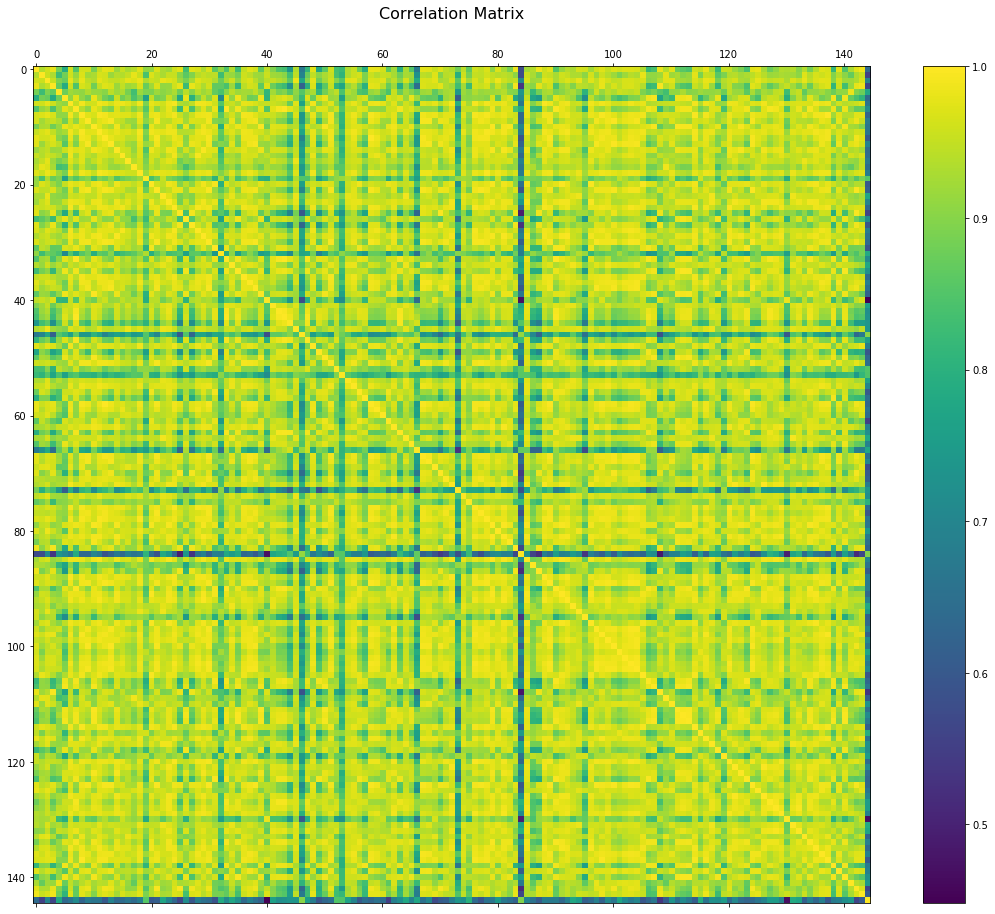

In [61]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted_GDP_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We then try to clusterize this correlation matrix in order to find countries whose GDP are correlated:

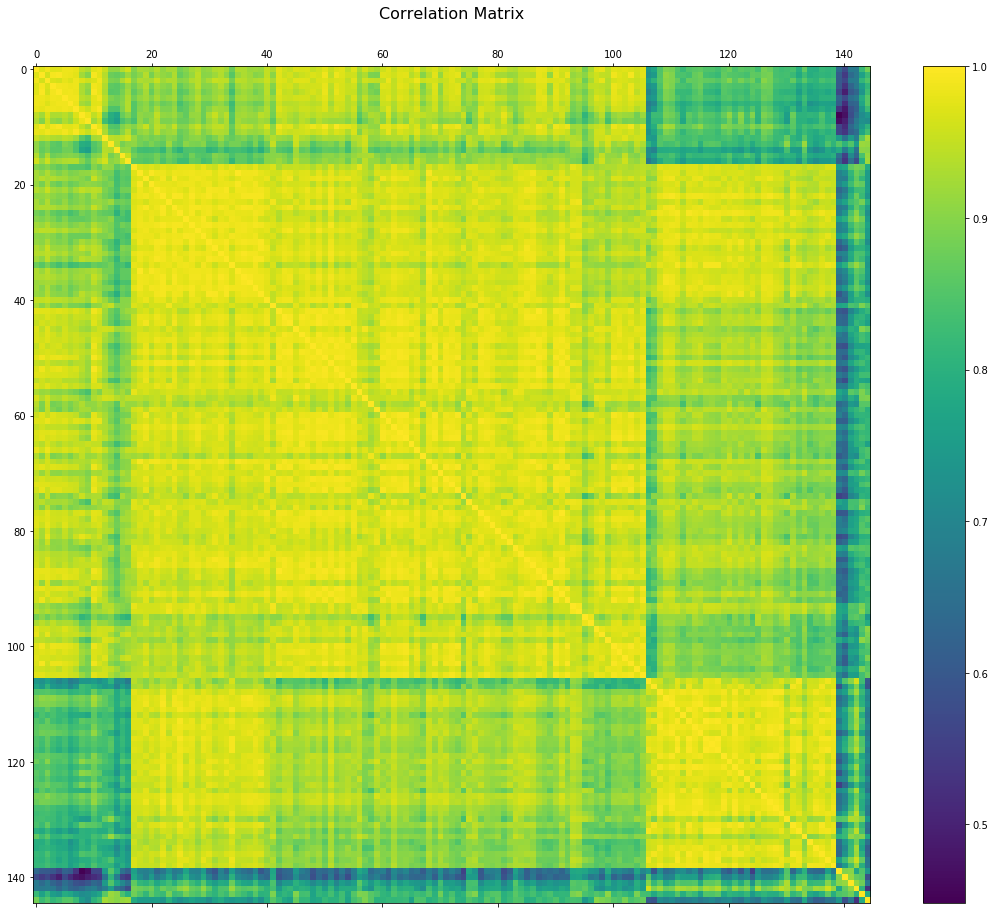

In [62]:
corr = pivoted_GDP_df.corr().values
pdist = spc.distance.pdist(corr)   # vector of ('55' choose 2) pairwise distances
linkage = spc.linkage(pdist, method='complete')
ind = spc.fcluster(linkage, 0.2*pdist.max(), 'distance')
columns = [pivoted_GDP_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
clusterised_df = pivoted_GDP_df.reindex(columns, axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(clusterised_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We have found regions in which the GDP is highly correlated and between which the correlation coefficent is lower. We could refine the big clusters by iterating this method.

**Interpretation:** The correlation matrix of GDP contains lots of values that are very closed to one. This means that GDP in two different countries have a trend to evolve the same way. Therefore, we can say that the world countries have strong enough trading relations to make the GDP evolve the same way. The fact that we have found some main clusters could be interpreted as regions in which the trading relations are more important.

#### 2.D. Economic classification of countries <a name="2D"></a>

In [63]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df["(GDP, million $)"]
for year in range(1980, 2015, 5):
    display(year, visualise_world_data_folium(plot, year, True))

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Martin\.conda\envs\ada\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 7.087833117559289] is not finite

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Analysis of food production and trade with GDP](#3C)
        
        1. [Correlation between production features and GDP](#3Ca)
        
        2. [Correlation between food trade features and GDP](#3Cb)
        
        3. [Machine learning model](#3Cc)  
        
            1. [Model - based on trade](#3Cci)  
        
            2. [Model - based on production](#3Ccii) 

    3. [Food prices stability and agricultural features](#3C)  
  

#### 3.A. Production and consumption of food from a time-space geography point of view <a name="3A"></a>

#### 3.B. Food self-sufficiency <a name="3B"></a>

#### 3.C. Analysis of food production and trade with GDP <a name="3C"></a>

##### 3.C.a. Food production and GDP <a name="3Ca"></a>

Out of the crops and the livestock produced, we will focus on the top 20 crops as well as top 20 livestock produced globally to be able to have a model with a reasonable amount of feautures. 

In [ ]:
#Choose the top 20 crops produced in the world for the first model
crop_production_df= uni_df.filter(like='Crops Production tonnes') 
crop_production_df = crop_production_df.sum(axis=0).sort_values(ascending=False)
crop_production_list = crop_production_df.index.tolist()[:20]
crop_production_list.insert(0,'(GDP, million $)')
crop_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
maincrops_df = uni_df[crop_production_list]

#Livestock
livestock_production_df= uni_df.filter(like='Livestock production') 
livestock_production_df = livestock_production_df.sum(axis=0).sort_values(ascending=False)
livestock_production_list = livestock_production_df.index.tolist()[:20]
livestock_production_list.insert(0,'(GDP, million $)')
livestock_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
mainlivestock_df = uni_df[livestock_production_list]

top_production_list = crop_production_list +livestock_production_list[1:]

top_production_df = uni_df[top_production_list]
top_production_df.head(5)

In [ ]:
#Checking correlations of main crops between each other and with GDP
mainprod_correlation_matrix = round (top_production_df.corr(method='pearson'),3)
mainprod_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)



Because "Cereals (Rice Milled Eqv) Crops Production tonnes" has such a high correlation with a lot of other features, it is probably an aggregate of them (eg over 90% with wheat).

In [ ]:
#Looking at some relationships
for item in list(top_production_df.columns)[1:]:
    top_production_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


We can quite clearly see that the production of many of the most popular crops can well be related to GDP.

##### 3.C.b. Trade and GDP <a name="3Cb"></a>

Let's see if the same can be said about the most exported/imported goods.

In [ ]:
#Choose the top 20 most exported items by mass
top_exports_df= uni_df.filter(like='export quantities tonnes')
top_exports_df = top_exports_df.sum(axis=0).sort_values(ascending=False)
top_exports_list =top_exports_df.index.tolist()[:20]
top_exports_list

#Take the top 20 exported crops and the columns of our uni_df which contain their production
top_exports_list.insert(0,'(GDP, million $)')
top_exports_df = uni_df[top_exports_list]


#Choose the top 20 most imported items by mass
top_imports_df= uni_df.filter(like='import quantities tonnes')
top_imports_df = top_imports_df.sum(axis=0).sort_values(ascending=False)

top_imports_list =top_imports_df.index.tolist()[:20]
top_imports_list

#Take the top 20 imported items and the columns of our uni_df which contain their production
top_imports_list.insert(0,'(GDP, million $)')
top_imports_df = uni_df[top_imports_list]

#Create a joined list
top_traded_list = top_exports_list +top_imports_list[1:]

In [ ]:

top_traded_df = uni_df[top_traded_list]
top_traded_df.head(5)

In [ ]:
#Checking correlations of main traded goods between each other and with GDP
top_traded_correlation_matrix = round (top_traded_df.corr(method='pearson'),3)
top_traded_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)


It seems that the most high correlations can be found from  exports of meat as well as feeding stuff. 

In [ ]:
#Looking at some relationships
for item in list(top_traded_df.columns)[1:]:
    top_traded_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


##### 3.C.c. Machine learning model <a name="3Cc"></a>

###### 3.C.c.i. Model - based on production <a name="3Cci"></a>

First, we only create a model using the production data. Afterwards, we use the data on exports, imports. 

#### Standardization, scaling


Clearly seeing that our data isn't normally distributed, this means we shouldn't use standardization. We'll use a min-max scaling to make different quantities comparable in the same model. 

In [ ]:
sns.distplot(maincrops_df["Sugar cane Crops Production tonnes"], rug=False, hist=False)

In [ ]:
sns.distplot(np.log(maincrops_df["Maize Crops Production tonnes"]), rug=False, hist=False)

We can clearly see that the production is not normally distributed, thus we shouldn't use a normalization of our features.
The huge peak is probably from all the Nan values we set to the median...

In [ ]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_production_values = top_production_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_production_minmaxed_values = min_max_scaler.fit_transform(top_production_values)
top_production_minmaxed = pd.DataFrame(top_production_minmaxed_values, columns=top_production_df.columns)
top_production_minmaxed.head(5)

In [ ]:
train_set, test_set = train_test_split(top_production_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

In [ ]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [ ]:
#this means I choose my alpha as 0??
# We build our model with the chosen alpha.
model_top_production = Ridge(alpha=0)
model_top_production.fit(X_train_set, Y_train_set)



In [ ]:
weights_top_production = pd.DataFrame([model_top_production.coef_], columns=top_production_df.columns[1:])
weights_top_production = weights_top_production.sort_values(by=0, axis=1, ascending=False)                                  
weights_top_production

In [ ]:
model_top_production.score(X_train_set, Y_train_set)

The result doesn't seem to make sense!! probably because chickens and poultry are so highly correlated. 

###### 3.C.c.ii. Model - based on trade <a name="3Ccii"></a>

In [ ]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_traded_values = top_traded_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_traded_minmaxed_values = min_max_scaler.fit_transform(top_traded_values)
top_traded_minmaxed = pd.DataFrame(top_traded_minmaxed_values, columns=top_traded_df.columns)
top_traded_minmaxed.head(5)

In [ ]:
train_set, test_set = train_test_split(top_traded_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

In [ ]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [ ]:
# We build our model with the chosen alpha.
model_trade = Ridge(alpha=0)
model_trade.fit(X_train_set, Y_train_set)



In [ ]:
weights_trade = pd.DataFrame([model_trade.coef_], columns=top_traded_minmaxed.columns[1:])
weights_trade = weights_trade.sort_values(by=0, axis=1, ascending=False)                                  
weights_trade

In [ ]:
model_trade.score(X_train_set, Y_train_set)

This needs to be cleaned, bc obviously the one with highest and lowest weights are actually super related.

#### 3.D. Food prices stability and agricultural features <a name="3D"></a>

### 4. Informed plan for next actions  <a name="4"></a>

Our results seem pretty intersting to share to the world. Moreover we have nice interactive maps and we would like to focus more on visual and style than writting on methodology. Therefore, we would like to produce a data story.
